### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

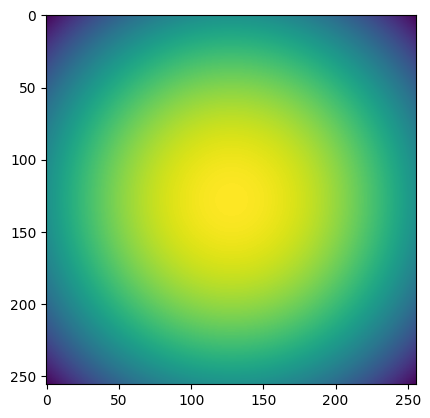

In [34]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 256 #[256, 512, 1024]



##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [35]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5


Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

$$
F_N /\left(E^* L^2 h^\prime_{\mathrm{rms}}\right)
$$

In [36]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)

p_target = p_target / (E_star*h_rms_prime)

Fn_Johnson = W / (E_star*h_rms_prime)

#solver.solve(p_target)
time_steps_list = [20, 30, 50, 80, 100, 150, 250, 400, 800, 1200, 1600]
#L2_norms = []
error_list = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 1/np.min(characteristic_time)



In [37]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

In [38]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for t in np.linspace(t0, t1, time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * Fn_Johnson * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    print(Ac_tamaas)
    print(Ac_Johnson_ref)
    print(len(Ac_tamaas))
    print(len(Ac_Johnson_ref))

    '''
    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))

    # normalize L2 error
    L2_error /= np.sqrt(len(Ac_tamaas))   
    '''
    #L2_error = np.linalg.norm(np.array(Ac_tamaas) - np.array(Ac_Johnson_ref)) / np.sqrt(len(Ac_tamaas))
    L2_norm = np.sqrt(np.sum(dt*(np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    error = L2_norm / np.linalg.norm(Ac_Johnson_ref)
    error_list.append(error)
    #L2_norms.append(L2_error)


 Iter          Cost_f           Error
    0    1.717311e-06    5.270364e-01
   31    2.655441e-04    6.867862e-13
 Iter          Cost_f           Error
    0    8.608370e-05    3.803557e-05
   10    2.764127e-04    8.677048e-13
 Iter          Cost_f           Error
    0    9.373103e-05    3.586208e-05
   11    2.869202e-04    1.157192e-13
 Iter          Cost_f           Error
    0    1.011050e-04    3.382577e-05
   10    2.970834e-04    7.182793e-13
 Iter          Cost_f           Error
    0    1.082193e-04    3.191698e-05
   11    3.069175e-04    1.049659e-13
 Iter          Cost_f           Error
    0    1.150865e-04    3.012680e-05
   11    3.164372e-04    1.159548e-13
 Iter          Cost_f           Error
    0    1.217186e-04    2.844699e-05
   11    3.256561e-04    1.107312e-13
 Iter          Cost_f           Error
    0    1.281957e-04    2.686134e-05
   13    3.345927e-04    4.646823e-14
 Iter          Cost_f           Error
    0    1.346687e-04    3.794300e-05
   17    3.4

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625)]
[np.float64(0.001021410080659021), np.float64(0.0010373503211774766), np.float64(0.0010527798847366583), np.float64(0.0010677203355383131), np.float64(0.0010821918858228646), np.float64(0.001096213520152793), np.float64(0.0011098031045283802), np.float64(0.0011229774825996163), np.float64(0.0011357525608442472), np.float64(0.0011481433842656893), np.float64(0.0011601642039088683), np.floa

 Iter          Cost_f           Error
    0    1.229186e-04    1.911646e-05
   11    3.277030e-04    6.387076e-14
 Iter          Cost_f           Error
    0    1.273090e-04    1.839585e-05
   10    3.338131e-04    8.288839e-13
 Iter          Cost_f           Error
    0    1.316538e-04    1.770006e-05
   12    3.398045e-04    5.368103e-13
 Iter          Cost_f           Error
    0    1.359693e-04    2.549894e-05
   12    3.457290e-04    7.881685e-14
 Iter          Cost_f           Error
    0    1.403390e-04    2.454481e-05
   13    3.515514e-04    2.650118e-13
 Iter          Cost_f           Error
    0    1.445877e-04    2.369410e-05
   12    3.572974e-04    7.303821e-14
 Iter          Cost_f           Error
    0    1.487631e-04    2.279980e-05
   12    3.629107e-04    7.116761e-14
 Iter          Cost_f           Error
    0    1.528338e-04    2.194260e-05
   12    3.683953e-04    7.350534e-14
 Iter          Cost_f           Error
    0    1.568253e-04    2.111961e-05
   16    3.7

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625)]
[np.float64(0.0010159792440422668), np.float64(0.0010267816269665978), 

   11    2.976157e-04    4.505418e-14
 Iter          Cost_f           Error
    0    1.039462e-04    1.360663e-05
   10    3.017733e-04    3.527435e-13
 Iter          Cost_f           Error
    0    1.069219e-04    1.328840e-05
   11    3.058758e-04    4.336761e-14
 Iter          Cost_f           Error
    0    1.098548e-04    1.297840e-05
   10    3.099243e-04    3.566200e-13
 Iter          Cost_f           Error
    0    1.127457e-04    1.267641e-05
   11    3.139197e-04    4.165335e-14
 Iter          Cost_f           Error
    0    1.155956e-04    1.238218e-05
   10    3.178630e-04    3.310493e-13
 Iter          Cost_f           Error
    0    1.184051e-04    1.209549e-05
   11    3.217551e-04    4.007110e-14
 Iter          Cost_f           Error
    0    1.211752e-04    1.181613e-05
   10    3.255970e-04    3.693410e-13
 Iter          Cost_f           Error
    0    1.239065e-04    1.154388e-05
   11    3.293894e-04    3.846737e-14
 Iter          Cost_f           Error
    0    1.2

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.floa

   10    2.897027e-04    1.005914e-13
 Iter          Cost_f           Error
    0    9.698545e-05    9.039858e-06
   11    2.924058e-04    2.908381e-14
 Iter          Cost_f           Error
    0    9.893713e-05    8.905633e-06
   10    2.950861e-04    1.597204e-13
 Iter          Cost_f           Error
    0    1.008708e-04    8.773620e-06
   11    2.977438e-04    2.836505e-14
 Iter          Cost_f           Error
    0    1.027868e-04    8.643778e-06
   10    3.003792e-04    2.108829e-13
 Iter          Cost_f           Error
    0    1.046852e-04    8.516068e-06
   11    3.029927e-04    2.763607e-14
 Iter          Cost_f           Error
    0    1.065663e-04    8.390449e-06
   10    3.055844e-04    8.820776e-14
 Iter          Cost_f           Error
    0    1.084303e-04    8.266884e-06
   11    3.081545e-04    2.697256e-14
 Iter          Cost_f           Error
    0    1.102775e-04    8.145335e-06
   10    3.107034e-04    3.245288e-13
 Iter          Cost_f           Error
    0    1.1

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

   10    2.855071e-04    1.874285e-13
 Iter          Cost_f           Error
    0    9.350864e-05    7.441576e-06
   11    2.877086e-04    2.379470e-14
 Iter          Cost_f           Error
    0    9.510361e-05    7.352631e-06
   10    2.898950e-04    6.639349e-14
 Iter          Cost_f           Error
    0    9.668669e-05    7.264868e-06
   11    2.920666e-04    2.336336e-14
 Iter          Cost_f           Error
    0    9.825800e-05    7.178268e-06
   10    2.942235e-04    1.255030e-13
 Iter          Cost_f           Error
    0    9.981768e-05    7.092815e-06
   11    2.963658e-04    2.284224e-14
 Iter          Cost_f           Error
    0    1.013658e-04    7.008491e-06
   10    2.984937e-04    1.149391e-13
 Iter          Cost_f           Error
    0    1.029026e-04    6.925280e-06
   11    3.006073e-04    2.245354e-14
 Iter          Cost_f           Error
    0    1.044281e-04    6.843165e-06
   10    3.027068e-04    9.849370e-14
 Iter          Cost_f           Error
    0    1.0

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

   10    2.797730e-04    1.175347e-13
 Iter          Cost_f           Error
    0    8.873766e-05    5.155129e-06
   10    2.812763e-04    7.993372e-13
 Iter          Cost_f           Error
    0    8.983196e-05    5.113706e-06
   10    2.827727e-04    1.057507e-13
 Iter          Cost_f           Error
    0    9.092075e-05    5.072654e-06
   10    2.842623e-04    7.874643e-13
 Iter          Cost_f           Error
    0    9.200406e-05    5.031968e-06
   10    2.857450e-04    1.326814e-13
 Iter          Cost_f           Error
    0    9.308194e-05    4.991645e-06
   10    2.872210e-04    7.821466e-13
 Iter          Cost_f           Error
    0    9.415441e-05    4.951682e-06
   10    2.886902e-04    1.491189e-13
 Iter          Cost_f           Error
    0    9.522153e-05    4.912074e-06
   10    2.901527e-04    7.751364e-13
 Iter          Cost_f           Error
    0    9.628332e-05    4.872819e-06
    9    2.916086e-04    9.989269e-13
 Iter          Cost_f           Error
    0    9.7

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

 Iter          Cost_f           Error
    0    8.480555e-05    3.190212e-06
   10    2.759868e-04    4.840485e-13
 Iter          Cost_f           Error
    0    8.547759e-05    3.174727e-06
    9    2.769039e-04    6.217828e-13
 Iter          Cost_f           Error
    0    8.614757e-05    3.159325e-06
   10    2.778184e-04    4.826281e-13
 Iter          Cost_f           Error
    0    8.681551e-05    3.144007e-06
    9    2.787304e-04    6.150471e-13
 Iter          Cost_f           Error
    0    8.748140e-05    3.128771e-06
   10    2.796399e-04    4.868979e-13
 Iter          Cost_f           Error
    0    8.814526e-05    3.113618e-06
    9    2.805469e-04    6.284725e-13
 Iter          Cost_f           Error
    0    8.880710e-05    3.098546e-06
   10    2.814513e-04    4.724646e-13
 Iter          Cost_f           Error
    0    8.946693e-05    3.083556e-06
    9    2.823533e-04    6.132209e-13
 Iter          Cost_f           Error
    0    9.012476e-05    3.068646e-06
   10    2.8

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

    9    2.723725e-04    4.081357e-13
 Iter          Cost_f           Error
    0    8.254725e-05    2.029043e-06
   10    2.729537e-04    3.067496e-13
 Iter          Cost_f           Error
    0    8.297286e-05    2.022864e-06
    9    2.735338e-04    4.048607e-13
 Iter          Cost_f           Error
    0    8.339764e-05    2.016706e-06
   10    2.741129e-04    3.051594e-13
 Iter          Cost_f           Error
    0    8.382161e-05    2.010568e-06
    9    2.746910e-04    4.020377e-13
 Iter          Cost_f           Error
    0    8.424476e-05    2.004451e-06
   10    2.752680e-04    3.037120e-13
 Iter          Cost_f           Error
    0    8.466710e-05    1.998355e-06
    9    2.758441e-04    3.941302e-13
 Iter          Cost_f           Error
    0    8.508862e-05    1.992280e-06
   10    2.764192e-04    3.025656e-13
 Iter          Cost_f           Error
    0    8.550934e-05    1.986226e-06
    9    2.769933e-04    3.926133e-13
 Iter          Cost_f           Error
    0    8.5

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

 Iter          Cost_f           Error
    0    8.063916e-05    1.029459e-06
    9    2.703936e-04    6.721067e-13
 Iter          Cost_f           Error
    0    8.085433e-05    1.027886e-06
    9    2.706866e-04    8.972430e-13
 Iter          Cost_f           Error
    0    8.106929e-05    1.026316e-06
    9    2.709793e-04    6.709874e-13
 Iter          Cost_f           Error
    0    8.128405e-05    1.024749e-06
    9    2.712718e-04    8.949816e-13
 Iter          Cost_f           Error
    0    8.149859e-05    1.023184e-06
    9    2.715640e-04    6.720068e-13
 Iter          Cost_f           Error
    0    8.171293e-05    1.021622e-06
    9    2.718560e-04    8.927466e-13
 Iter          Cost_f           Error
    0    8.192706e-05    1.020063e-06
    9    2.721477e-04    6.724112e-13
 Iter          Cost_f           Error
    0    8.214098e-05    1.018506e-06
    9    2.724392e-04    8.904971e-13
 Iter          Cost_f           Error
    0    8.235469e-05    1.016952e-06
    9    2.7

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

    9    2.695336e-04    6.014478e-13
 Iter          Cost_f           Error
    0    8.014175e-05    6.889613e-07
    8    2.697296e-04    7.900165e-13
 Iter          Cost_f           Error
    0    8.028564e-05    6.882591e-07
    9    2.699255e-04    6.005107e-13
 Iter          Cost_f           Error
    0    8.042943e-05    6.875574e-07
    8    2.701213e-04    7.884305e-13
 Iter          Cost_f           Error
    0    8.057313e-05    6.868567e-07
    9    2.703169e-04    5.994534e-13
 Iter          Cost_f           Error
    0    8.071673e-05    6.861567e-07
    8    2.705124e-04    7.873976e-13
 Iter          Cost_f           Error
    0    8.086025e-05    6.854577e-07
    9    2.707078e-04    5.984851e-13
 Iter          Cost_f           Error
    0    8.100367e-05    6.847592e-07
    8    2.709031e-04    7.857825e-13
 Iter          Cost_f           Error
    0    8.114699e-05    6.840617e-07
    9    2.710983e-04    5.975170e-13
 Iter          Cost_f           Error
    0    8.1

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

 Iter          Cost_f           Error
    0    7.978425e-05    5.181168e-07
    9    2.692496e-04    4.517135e-13
 Iter          Cost_f           Error
    0    7.989238e-05    5.177203e-07
    8    2.693968e-04    5.932224e-13
 Iter          Cost_f           Error
    0    8.000046e-05    5.173243e-07
    9    2.695439e-04    4.511861e-13
 Iter          Cost_f           Error
    0    8.010849e-05    5.169286e-07
    8    2.696910e-04    5.925398e-13
 Iter          Cost_f           Error
    0    8.021646e-05    5.165334e-07
    9    2.698379e-04    4.505866e-13
 Iter          Cost_f           Error
    0    8.032438e-05    5.161383e-07
    8    2.699848e-04    5.917956e-13
 Iter          Cost_f           Error
    0    8.043225e-05    5.157436e-07
    9    2.701317e-04    4.500510e-13
 Iter          Cost_f           Error
    0    8.054007e-05    5.153493e-07
    8    2.702785e-04    5.910959e-13
 Iter          Cost_f           Error
    0    8.064783e-05    5.149553e-07
    9    2.7

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

In [39]:
print(error_list)

[np.float64(0.018618377982227832), np.float64(0.01560302830815659), np.float64(0.012211108096722614), np.float64(0.009490641219397609), np.float64(0.00854394332737807), np.float64(0.006963422511887839), np.float64(0.00540874692059123), np.float64(0.004282237332707938), np.float64(0.0030221946052954645), np.float64(0.002466528177516994), np.float64(0.002136267677321581)]


[np.float64(0.05), np.float64(0.03333333333333333), np.float64(0.02), np.float64(0.0125), np.float64(0.01), np.float64(0.006666666666666667), np.float64(0.004), np.float64(0.0025), np.float64(0.00125), np.float64(0.0008333333333333334), np.float64(0.000625)]


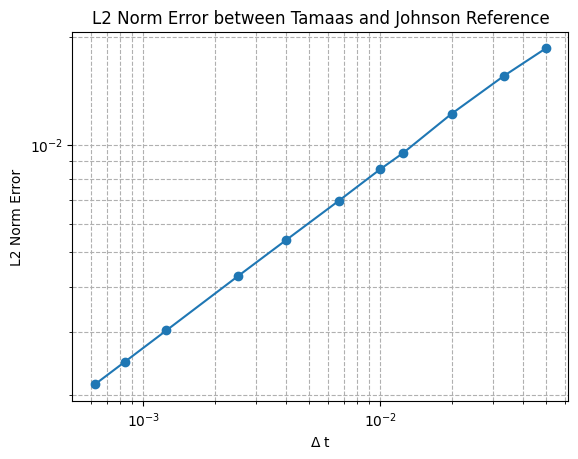

In [40]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, error_list, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.show()